In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.io.io_results import load_results, group_results_by_subject
from utils.preparation.decomp import compute_hht

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/fc"

In [4]:
### Compute marginal Hilbert spectrum for a given network
def compute_network_marginal_spectrum(inst_amp, inst_freq, roi_to_net,
                                      net_idx, fs, fmax=0.25, nbins=200):
    """
    inst_amp, inst_freq: arrays (K, T, R)
    roi_to_net: array (R,), mapping ROIs to network IDs (0..n_networks-1)
    net_idx: which network to compute the spectrum for
    Returns:
        freqs: (nbins,)
        marginal: (nbins,) marginal Hilbert spectrum for that network
    """
    K, T, R = inst_amp.shape
    freq_bins = np.linspace(0, fmax, nbins + 1)

    # ROIs belonging to this network
    mask_roi = (roi_to_net == net_idx)
    if not np.any(mask_roi):
        return None, None

    # Average amplitude and frequency across ROIs of this network
    amp_net = inst_amp[:, :, mask_roi].mean(axis=2)   # (K, T)
    frq_net = inst_freq[:, :, mask_roi].mean(axis=2)  # (K, T)

    # Bin by frequency
    inds = np.digitize(frq_net, freq_bins) - 1
    inds = inds.clip(0, len(freq_bins) - 2)

    H = np.zeros(len(freq_bins) - 1)

    # Accumulate amplitude into frequency bins for all IMFs and time points
    for k in range(K):
        np.add.at(H, inds[k, :], amp_net[k, :])

    # Average over time (discrete approximation of integral over t)
    H /= T

    # Frequency bin centers
    freqs = 0.5 * (freq_bins[:-1] + freq_bins[1:])
    return freqs, H

## For plotting
def add_freq_bands(ax, freq_bands, alpha=0.15):
    """Shade canonical fMRI frequency bands with predefined colors."""
    colors = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f"]  # Slow-5..Slow-2
    for (band, (fmin, fmax)), c in zip(freq_bands.items(), colors):
        ax.axvspan(fmin, fmax, color=c, alpha=alpha, zorder=0)

In [5]:
results = load_results(RES_DIR)
subjects_dict = group_results_by_subject(results)

[Load] Loaded 165 FC result files from /cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/fc


In [6]:
freq_bands = {
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

In [7]:
groups = { subj: entries[0]["group"] 
               for subj, entries in subjects_dict.items() 
            }

In [8]:
# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)


In [9]:
fs = 1 / 0.8  # TR = 0.8 s
fmax = 0.25
nbins = 200

# For each network: group -> list of spectra (one per subject)
net_marginals = {
    net_idx: {"MDD": [], "HC": []}
    for net_idx in range(n_networks)
}

# We’ll also store freqs once (same for all subjects if params are fixed)
freqs_ref = None

for subj, entries in subjects_dict.items():
    e = entries[0]
    imfs = e["imfs"]  # (K, T, R)
    group = groups[subj]  # "MDD" or "HC"

    inst_amp, inst_freq = compute_hht(imfs, fs=fs, smooth_sigma=1)

    for net_idx in range(n_networks):
        freqs, H = compute_network_marginal_spectrum(
            inst_amp, inst_freq, roi_to_net, net_idx, fs=fs, fmax=fmax, nbins=nbins
        )
        if freqs is None:
            continue

        if freqs_ref is None:
            freqs_ref = freqs  # store first non-empty

        net_marginals[net_idx][group].append(H)


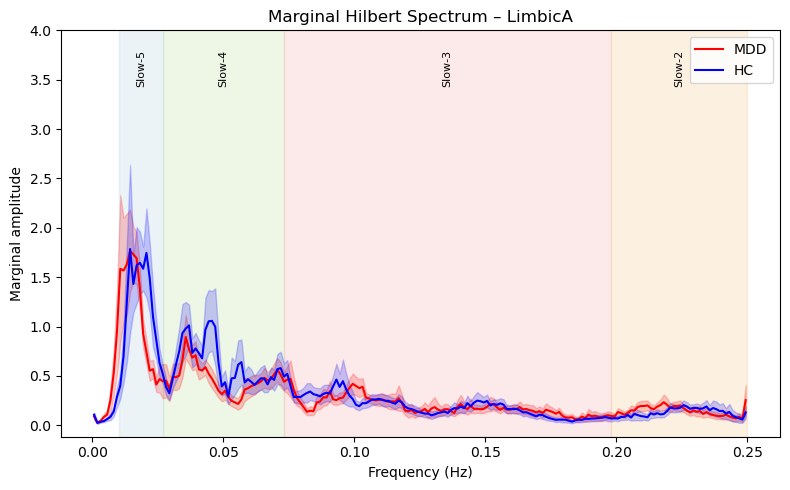

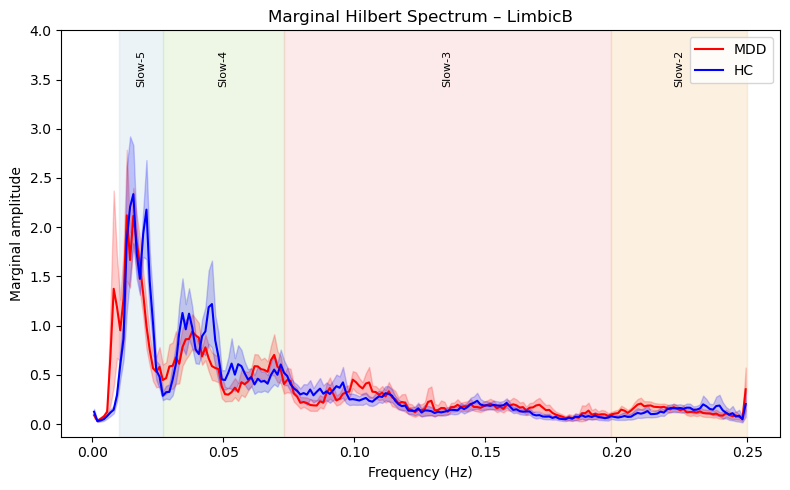

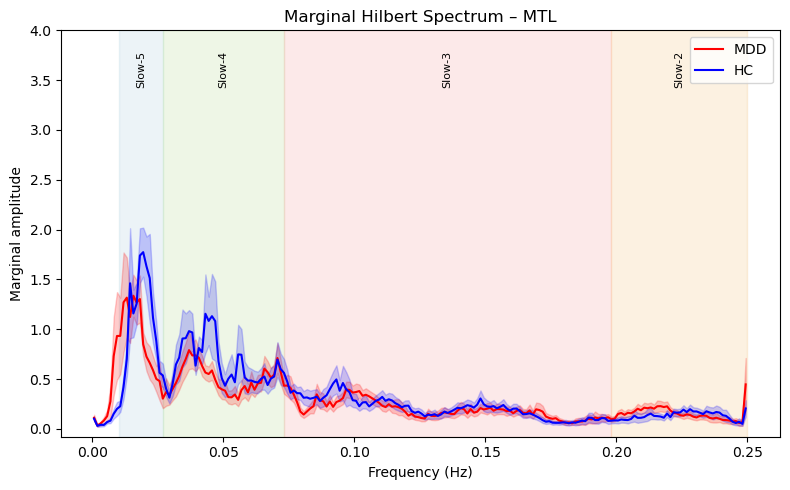

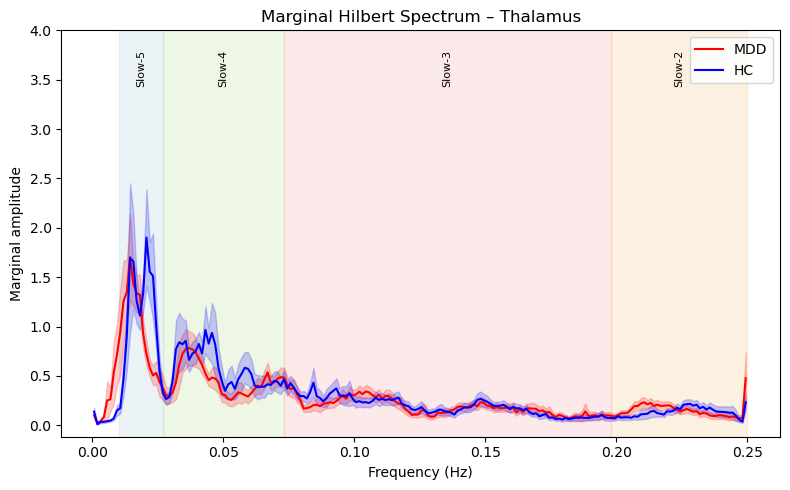

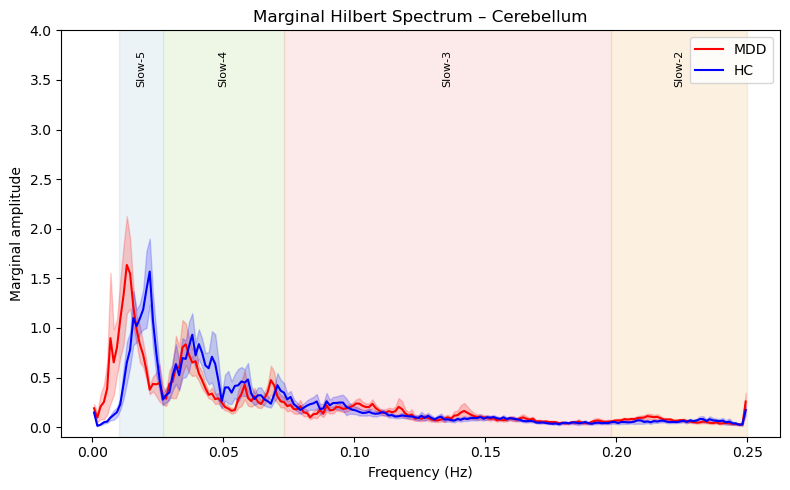

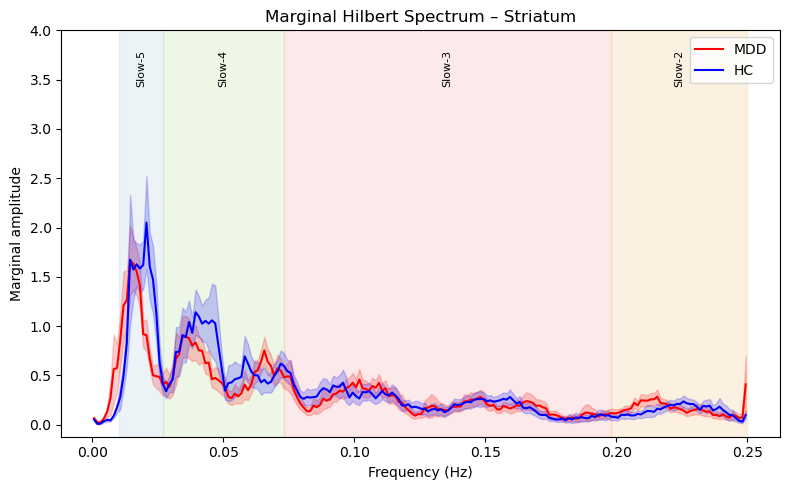

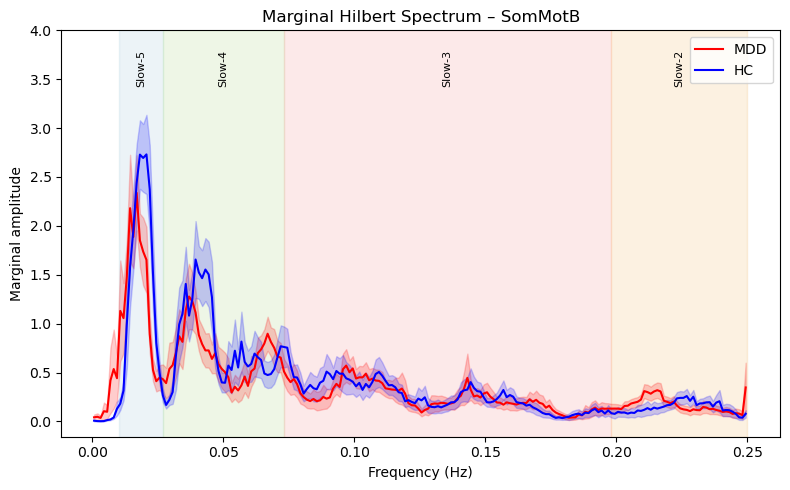

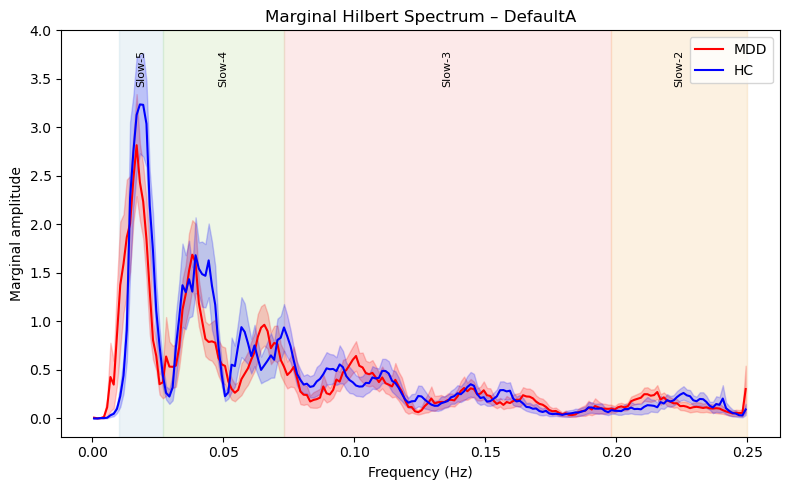

In [10]:
net_list = ["LimbicA", "LimbicB", "MTL", "Thalamus",  "Cerebellum", "Striatum", "SomMotB", "DefaultA"]
#net_list = ["ContA", "ContB", "ContC", "DefaultB", "DefaultC", "DorsAttnA", "DorsAttnB", "SalVentAttnA", "SalVentAttnB", "SomMotA", "TempPar", "VisCent", "VisPeri"]

for net_name in net_list:
    net_idx = net_names_21.index(net_name)

    mdd_arr = np.vstack(net_marginals[net_idx]["MDD"])  # (n_MDD, nbins)
    hc_arr  = np.vstack(net_marginals[net_idx]["HC"])   # (n_HC, nbins)

    mdd_mean = mdd_arr.mean(axis=0)
    hc_mean  = hc_arr.mean(axis=0)

    mdd_se = mdd_arr.std(axis=0) / np.sqrt(mdd_arr.shape[0])
    hc_se  = hc_arr.std(axis=0) / np.sqrt(hc_arr.shape[0])

    # ---- Create figure FIRST ----
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot group mean ± SE
    ax.plot(freqs_ref, mdd_mean, label="MDD", color="red")
    ax.fill_between(freqs_ref, mdd_mean - mdd_se, mdd_mean + mdd_se,
                    color="red", alpha=0.2)

    ax.plot(freqs_ref, hc_mean, label="HC", color="blue")
    ax.fill_between(freqs_ref, hc_mean - hc_se, hc_mean + hc_se,
                    color="blue", alpha=0.2)

    # y-limits based on data
    ymin, ymax = ax.get_ylim()

    # ---- Colored frequency bands ----
    add_freq_bands(ax, freq_bands, alpha=0.20)
    for band, (fmin, fmax) in freq_bands.items():
        ax.text((fmin + fmax)/2, 0.95*4, band, ha="center", va="top", fontsize=8, rotation=90)

    # Optional: shade whole band lightly (0.01–0.25 Hz)
    ax.axvspan(0.01, 0.25, color="lightgrey", alpha=0.03, zorder=0)

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Marginal amplitude")
    ax.set_ylim(ymin, 4)  # or (ymin, 4) if you really want to fix max
    ax.set_title(f"Marginal Hilbert Spectrum – {net_name}")
    ax.legend()
    fig.tight_layout()
    plt.show()
